# Pollywog Basic Usage Example

This notebook demonstrates how to use the `pollywog` library to create, read, and write Leapfrog calculation sets (`.lfcalc` files).

In [1]:
import sys

p = ".."
if p not in sys.path:
    sys.path.insert(0, p)

import pollywog as pw

In [2]:
# Optional: Set display theme ("light" or "dark")
from pollywog.display import set_theme

set_theme("light")  # or "dark"

## 1. Creating a Calculation Set

Let's create a simple calculation set with a numeric calculation using `pollywog`. 

In [3]:
from pollywog.core import CalcSet, Number

# Create a simple numeric calculation
num = Number(name="example_num", children=["2 + 2"])
calcset = CalcSet([num])

# Show the calculation set as a dictionary
calcset_dict = calcset.to_dict()
calcset_dict

{'type': 'calculation-set',
 'items': [{'type': 'calculation',
   'name': 'example_num',
   'equation': {'type': 'equation',
    'comment': '',
    'statement': {'type': 'list', 'children': ['2 + 2']}},
   'comment': '',
   'calculation_type': 'number'}]}

## 2. Writing to a Leapfrog .lfcalc File

You can write the calculation set to a Leapfrog `.lfcalc` file using the `to_lfcalc` method.

In [4]:
# Write the calculation set to a file
calcset.to_lfcalc("example.lfcalc")
print("Wrote example.lfcalc!")

Wrote example.lfcalc!


## 3. Reading a Leapfrog .lfcalc File

You can read a `.lfcalc` file back into a `CalcSet` object.

In [5]:
# Read the calculation set from the file
calcset2 = CalcSet.read_lfcalc("example.lfcalc")
calcset2

{
  "type": "calculation-set",
  "items": [
    {
      "type": "calculation",
      "name": "example_num",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "2 + 2"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    }
  ]
}

## 4. Postprocessing Variable Estimates

Suppose you have a set of estimated variables from Leapfrog and want to postprocess them, e.g., clip negative values and save the results to new variables with the suffix `_final`. This example shows how to automate that using `pollywog`.

In [6]:
# List of estimated variable names from Leapfrog
variables = [
    "Ag_est",
    "Au_est",
    "Cu_est",
    "Fe_est",
    "Pb_est",
    "Zn_est",
    "Ca_est",
    "Zn_est",
]

# Postprocess: clip negative values and save to new variables
from pollywog.core import CalcSet, Number
from pollywog.display import display_calcset

postprocessed = [
    Number(name=f"{v}_corr", children=[f"clamp([{v}], 0.01)"]) for v in variables
]

calcset_post = CalcSet(postprocessed)
calcset_post.to_lfcalc("postprocessed.lfcalc")
print("Wrote postprocessed.lfcalc!")

# Show the postprocessed calculation set visually
_ = display_calcset(calcset_post)
# If you want the raw dict, uncomment below:
# calcset_post.to_dict()

Wrote postprocessed.lfcalc!


## 5. Estimating Dilution by Domain Proportions

Suppose each block has estimated variables for several domains (e.g., LG, HG, waste) and you know the proportion of each domain in each block. You can calculate the final diluted variable as a weighted sum of the domain estimates using their proportions.

In [7]:
# Example variable names and domains
variables = ["Ag", "Au", "Cu"]
domains = ["LG", "HG", "waste"]

# For each block, Leapfrog provides:
# - estimated value for each variable in each domain (e.g., Ag_LG, Ag_HG, Ag_waste)
# - proportion of each domain in the block (e.g., prop_LG, prop_HG, prop_waste)

# We'll create final variables as weighted sums:
# Ag_final = Ag_LG * prop_LG + Ag_HG * prop_HG + Ag_waste * prop_waste

from pollywog.core import CalcSet, Number

weighted_vars = []
for v in variables:
    expr = (
        "("
        + " + ".join([f"[{v}_{d}] * [prop_{d}]" for d in domains])
        + ")/("
        + "+".join([f"[prop_{d}]" for d in domains])
        + ")"
    )
    weighted_vars.append(Number(name=f"{v}_final", children=[expr]))

calcset_weighted = CalcSet(weighted_vars)
calcset_weighted.to_lfcalc("weighted_final.lfcalc")
print("Wrote weighted_final.lfcalc!")

calcset_weighted

Wrote weighted_final.lfcalc!


{
  "type": "calculation-set",
  "items": [
    {
      "type": "calculation",
      "name": "Ag_final",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "([Ag_LG] * [prop_LG] + [Ag_HG] * [prop_HG] + [Ag_waste] * [prop_waste])/([prop_LG]+[prop_HG]+[prop_waste])"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    },
    {
      "type": "calculation",
      "name": "Au_final",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "([Au_LG] * [prop_LG] + [Au_HG] * [prop_HG] + [Au_waste] * [prop_waste])/([prop_LG]+[prop_HG]+[prop_waste])"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    },
    {
      "type": "calculation",
      "name": "Cu_final",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "([Cu_LG] * [prop_LG] + [Cu_HG] * [prop_HG] + [Cu_waste] * [prop_waste])/([prop_LG]+[prop_HG]+[prop_waste])"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    }
  ]
}

## 6. Further Postprocessing Examples

This section demonstrates several useful postprocessing steps:
- Thresholding for ore/waste classification
- Composite variables
- Conditional logic
- Recovery adjustment
- Economic value calculation

In [8]:
# Example variables and parameters
variables = ["Ag", "Au", "Cu"]
cutoffs = {"Ag": 5, "Au": 0.5, "Cu": 0.2}  # ppm or %
prices = {"Ag": 25, "Au": 2000, "Cu": 8}  # $/unit
equivalents = {"Ag": 2, "Au": 31, "Cu": 1}  # for metal equivalence
cost = 50  # $/block

from pollywog.core import CalcSet, Number, Filter, If

post_items = []

# 1. Thresholding for ore/waste classification
for v in variables:
    post_items.append(
        Filter(name=f"{v}_is_ore", children=[f"[{v}_final] > {cutoffs[v]}"])
    )

# 2. Equivalent copper calculation
post_items.append(
    Number(
        name="Cu_equiv",
        children=[
            " + ".join(
                [
                    f"[{v}_final] * {equivalents[v]}"
                    for v in variables
                    if v in equivalents
                ]
            )
        ],
    )
)

calcset_post2 = CalcSet(post_items)
calcset_post2.to_lfcalc("block_value.lfcalc")
print("Wrote block_value.lfcalc!")
calcset_post2

Wrote block_value.lfcalc!


{
  "type": "calculation-set",
  "items": [
    {
      "type": "calculation",
      "name": "Cu_equiv",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "[Ag_final] * 2 + [Au_final] * 31 + [Cu_final] * 1"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    },
    {
      "type": "filter",
      "name": "Ag_is_ore",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "[Ag_final] > 5"
          ]
        }
      },
      "comment": ""
    },
    {
      "type": "filter",
      "name": "Au_is_ore",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "[Au_final] > 0.5"
          ]
        }
      },
      "comment": ""
    },
    {
      "type": "filter",
      "name": "Cu_is_ore",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "[Cu_final] > 0.2"
          ]
        }
      },
      "comment": ""
    }
  ]
}

## 7. Using a Scikit-learn Regression Tree for Recovery

You can fit a regression tree model in scikit-learn and convert it to Leapfrog calculation format using `pollywog`. This allows you to use machine learning models for block recovery or other predictions directly in Leapfrog.

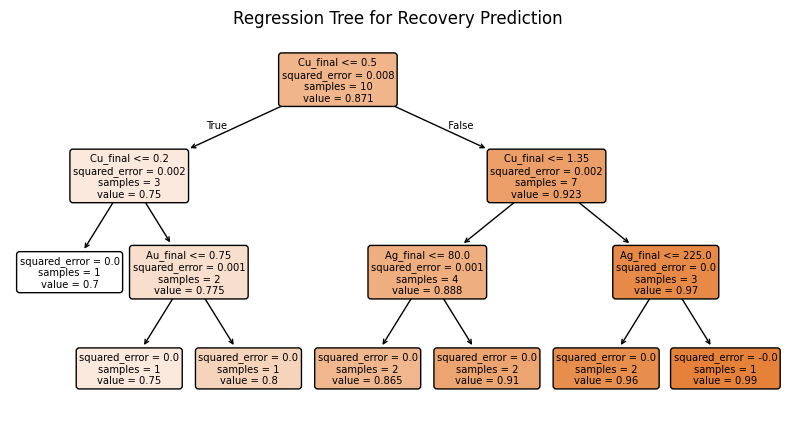

Wrote recovery_ml.lfcalc!


{
  "type": "calculation-set",
  "items": [
    {
      "type": "calculation",
      "name": "recovery_ml",
      "equation": {
        "type": "equation",
        "comment": "Converted from DecisionTreeRegressor",
        "statement": {
          "type": "list",
          "children": [
            "",
            {
              "type": "if",
              "rows": [
                {
                  "type": "if_row",
                  "test": {
                    "type": "list",
                    "children": [
                      "[Cu_final] <= 0.5000000149011612"
                    ]
                  },
                  "result": {
                    "type": "list",
                    "children": [
                      "",
                      {
                        "type": "if",
                        "rows": [
                          {
                            "type": "if_row",
                            "test": {
                              "type": "list",
                              "children": [
                                "[Cu_final] <= 0.20000000298023224"
                              ]
                            },
                            "result": {
                              "type": "list",
                              "children": [
                                "0.7"
                              ]
                            }
                          }
                        ],
                        "otherwise": {
                          "type": "list",
                          "children": [
                            "",
                            {
                              "type": "if",
                              "rows": [
                                {
                                  "type": "if_row",
                                  "test": {
                                    "type": "list",
                                    "children": [
                                      "[Au_final] <= 0.75"
                                    ]
                                  },
                                  "result": {
                                    "type": "list",
                                    "children": [
                                      "0.75"
                                    ]
                                  }
                                }
                              ],
                              "otherwise": {
                                "type": "list",
                                "children": [
                                  "0.8"
                                ]
                              }
                            },
                            ""
                          ]
                        }
                      },
                      ""
                    ]
                  }
                }
              ],
              "otherwise": {
                "type": "list",
                "children": [
                  "",
                  {
                    "type": "if",
                    "rows": [
                      {
                        "type": "if_row",
                        "test": {
                          "type": "list",
                          "children": [
                            "[Cu_final] <= 1.350000023841858"
                          ]
                        },
                        "result": {
                          "type": "list",
                          "children": [
                            "",
                            {
                              "type": "if",
                              "rows": [
                                {
                                  "type": "if_row",
                                  "test": {
                                    "type": "list",
                                    "children": [
                                      "[Ag_final] <= 80.0"
                                

In [9]:
# Fit a regression tree for recovery prediction
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from pollywog.conversion.sklearn import convert_tree

# Synthetic training data: features are block grades, target is recovery
# More realistic grade ranges (Cu in %, Au in g/t, Ag in g/t)
X = np.array(
    [
        [0.15, 0.3, 10],  # low Cu, low Au, low Ag
        [0.25, 0.5, 20],  # moderate Cu, moderate Au, moderate Ag
        [0.4, 1.0, 30],  # higher Cu, moderate Au, moderate Ag
        [0.6, 1.5, 50],  # high Cu, higher Au, higher Ag
        [0.8, 2.0, 70],  # very high Cu, high Au, high Ag
        [1.0, 2.5, 90],  # very high Cu, very high Au, very high Ag
        [1.2, 3.0, 120],  # extremely high Cu, very high Au, very high Ag
        [1.5, 4.0, 150],  # exceptional Cu, exceptional Au, exceptional Ag
        [2.0, 5.0, 200],  # rare high Cu, rare high Au, rare high Ag
        [2.5, 6.0, 250],  # extreme grades
    ]
)
y = np.array([0.7, 0.75, 0.8, 0.85, 0.88, 0.9, 0.92, 0.95, 0.97, 0.99])
feature_names = ["Cu_final", "Au_final", "Ag_final"]

# Train the tree
reg = DecisionTreeRegressor(max_depth=3)
reg.fit(X, y)

# Visualize the tree
plt.figure(figsize=(10, 5))
plot_tree(reg, feature_names=feature_names, filled=True, rounded=True)
plt.title("Regression Tree for Recovery Prediction")
plt.show()

# Convert to Leapfrog calculation
recovery_calc = convert_tree(reg, feature_names, "recovery_ml")

# Add to workflow and save
calcset_ml = CalcSet([recovery_calc])
calcset_ml.to_lfcalc("recovery_ml.lfcalc")
print("Wrote recovery_ml.lfcalc!")
calcset_ml  # .to_dict()

### Combining Multiple CalcSets for a Final Workflow

You can concatenate multiple `CalcSet` objects using the `+` operator to build a final calculation set that includes all your postprocessing steps and machine learning recovery.

In [10]:
from pollywog.core import CalcSet, Number, If


value_expr = (
    " + ".join([f"[{v}_recovered] * {prices[v]}" for v in variables]) + f" - {cost}"
)

calcset_conditional = CalcSet(
    [
        Number(
            f"{v}_recovered",
            children=If((f"[{v}_is_ore]", f"[{v}_final] * [recovery_ml]"), "0"),
        )
        for v in variables
    ]
    + [Number(name="block_value", children=[value_expr])]
)

# Concatenate with previous workflow
final_calcset2 = calcset_weighted + calcset_post2 + calcset_ml + calcset_conditional
final_calcset2.to_lfcalc("final_workflow_with_conditional.lfcalc")
print("Wrote final_workflow_with_conditional.lfcalc!")
final_calcset2  # .to_dict()

Wrote final_workflow_with_conditional.lfcalc!


{
  "type": "calculation-set",
  "items": [
    {
      "type": "calculation",
      "name": "Ag_final",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "([Ag_LG] * [prop_LG] + [Ag_HG] * [prop_HG] + [Ag_waste] * [prop_waste])/([prop_LG]+[prop_HG]+[prop_waste])"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    },
    {
      "type": "calculation",
      "name": "Au_final",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "([Au_LG] * [prop_LG] + [Au_HG] * [prop_HG] + [Au_waste] * [prop_waste])/([prop_LG]+[prop_HG]+[prop_waste])"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    },
    {
      "type": "calculation",
      "name": "Cu_final",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "([Cu_LG] * [prop_LG] + [Cu_HG] * [prop_HG] + [Cu_waste] * [prop_waste])/([prop_LG]+[prop_HG]+[prop_waste])"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    },
    {
      "type": "calculation",
      "name": "Cu_equiv",
      "equation": {
        "type": "equation",
        "comment": "",
        "statement": {
          "type": "list",
          "children": [
            "[Ag_final] * 2 + [Au_final] * 31 + [Cu_final] * 1"
          ]
        }
      },
      "comment": "",
      "calculation_type": "number"
    },
    {
      "type": "calculation",
      "name": "recovery_ml",
      "equation": {
        "type": "equation",
        "comment": "Converted from DecisionTreeRegressor",
        "statement": {
          "type": "list",
          "children": [
            "",
            {
              "type": "if",
              "rows": [
                {
                  "type": "if_row",
                  "test": {
                    "type": "list",
                    "children": [
                      "[Cu_final] <= 0.5000000149011612"
                    ]
                  },
                  "result": {
                    "type": "list",
                    "children": [
                      "",
                      {
                        "type": "if",
                        "rows": [
                          {
                            "type": "if_row",
                            "test": {
                              "type": "list",
                              "children": [
                                "[Cu_final] <= 0.20000000298023224"
                              ]
                            },
                            "result": {
                              "type": "list",
                              "children": [
                                "0.7"
                              ]
                            }
                          }
                        ],
                        "otherwise": {
                          "type": "list",
                          "children": [
                            "",
                            {
                              "type": "if",
                              "rows": [
                                {
                                  "type": "if_row",
                                  "test": {
                                    "type": "list",
                                    "children": [
                                      "[Au_final] <= 0.75"
                                    ]
                                  },
                                  "result": {
                                    "type": "list",
                                    "children": [
                                      "0.75"
                                    ]
                                  }
               